# CNN para clasificación de imágenes con Pytorch



##Introducción:
En este TP vamos a implementar redes neuronales convolucionales para la clasificación de imágenes. Vamos a usar el dataset de CIFAR10, que consta de 60000 imágenes en color de 32x32 en 10 clases, con 6000 imágenes por clase. las 10 clases son: avión, automóvil, pájaro, gato, ciervo, perro, rana, caballo, barco, camión.

Implementaremos un modelo base, y luego dos modelos más intentando mejorar el accuracy y la funcion de loss.

In [ ]:
# Importando líbrerias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler, random_split
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Desarrollo:

Del total de datos que son 60000 vamos a separar 5000 para validación y el resto (55000) para train.

Además de bajar los datos, los transformamos en tensor  y normalizamos deacuerdo a la media y desviación estandar por cada canal.

Creamos los grupos de training y de validación, utilizando la herramienta de pytorch SubsetRandomSampler.

In [ ]:
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

# Barajar los índices
indices = np.arange(50000)
np.random.shuffle(indices)
n_train = 45000

# Calcular las estadísticas de normalización
train_dataset = datasets.CIFAR10('.', download=True, train=True)

mean = np.mean(train_dataset.data / 255, axis=(0, 1, 2))
std = np.std(train_dataset.data / 255, axis=(0, 1, 2))

# Transformar los datos en tensores y normalizarlos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Importar el conjunto de datos CIFAR-10
dataset = datasets.CIFAR10('.', download=True, train=True, transform=transform)

# Construir el cargador de entrenamiento
train_loader = DataLoader(dataset,
                            batch_size=64, shuffle=False,
                            sampler=SubsetRandomSampler(indices[:n_train])
                            )

# Construir el cargador de validación
val_loader = DataLoader(dataset,
                            batch_size=64, shuffle=False,
                            sampler=SubsetRandomSampler(indices[n_train:])
                            )


100%|██████████| 170498071/170498071 [00:03<00:00, 43822714.12it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
len(train_loader), len(val_loader)

(704, 79)

In [ ]:
dataset[0][0].shape, dataset[0][1]

(torch.Size([3, 32, 32]), 6)

Vemos que los datos que tenemos son 3 canales, de 32x32 y la etiqueta correspondiente.

In [ ]:
train_loader.batch_size, val_loader.batch_size

(64, 64)

In [ ]:
def train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    # Ciclo for para el número de épocas
    train_loss_history, train_acc_history, val_loss_history, val_acc_history = [], [], [], []
    all_labels, all_preds = [], []
    model = model.to(device=device)
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        # Establecer el modelo en modo de entrenamiento
        model.train()
        y_true = []
        y_pred = []
        # Iterar sobre los datos de entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            # Calcular la pérdida
            loss = criterion(predicted_outputs, labels)
            loss.backward()
            optimizer.step()
            # Acumular la pérdida y la precisión
            train_loss += loss.item()
            # La etiqueta con mayor valor será nuestra predicción
            _, predicted = torch.max(predicted_outputs , 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

        # Calcular la pérdida y precisión promedio del entrenamiento
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        train_acc = accuracy_score(y_true, y_pred)
        train_acc_history.append(train_acc)

        # set the model to evaluation mode
        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
                # Run the forward pass
                predicted_outputs = model(inputs)
                # Compute loss
                loss = criterion(predicted_outputs, labels)
                # Accumulate the average loss of the mini-batch
                val_loss += loss.item()
                # The label with the highest value will be our prediction
                _, predicted = torch.max(predicted_outputs , 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        # calculate the average validation loss and accuracy
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        val_acc = accuracy_score(y_true, y_pred)
        val_acc_history.append(val_acc)
        all_labels.extend(y_true)
        all_preds.extend(y_pred)

        print(f'Epoch {epoch+1}/{num_epochs}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds


def plotting_confusion_matrix(all_labels, all_preds, title_name=''):

    # Plotting Confusion Matrix
    fig, axs = plt.subplots(1, 2, figsize = (14, 6))

    # Implementing visualization of Confusion Matrix
    c_m = confusion_matrix(all_labels, all_preds)
    c_m_normalized = confusion_matrix(all_labels, all_preds, normalize='true').round(3)

    ConfusionMatrixDisplay(c_m, display_labels=dataset.classes).plot(cmap='Greys', xticks_rotation=25, ax=axs[0])
    ConfusionMatrixDisplay(c_m_normalized*100, display_labels=dataset.classes).plot(cmap='Greys', xticks_rotation=25, ax=axs[1],)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    axs[0].set_title('Valores absolutos', fontsize=14)
    axs[1].set_title('Valores porcentuales', fontsize=14)
    plt.suptitle(f'Confusion Matrix {title_name}', fontsize=16)
    plt.show()


def plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    fig, axs = plt.subplots(1, 2, figsize = (10, 4))
    # Plot the training and validation loss
    axs[0].plot(train_loss_history, label='train loss')
    axs[0].plot(val_loss_history, label='val loss')
    axs[0].grid()
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')

    # Plot the training and validation accuracy
    axs[1].plot(train_acc_history, label='train acc')
    axs[1].plot(val_acc_history, label='val acc')
    axs[1].grid()
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')

    plt.legend()
    plt.tight_layout()  # Ajusta automáticamente el diseño para evitar superposiciones
    plt.show()

## Modelos

In [ ]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(8 * 8 * 32, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, self.fc.in_features)
        return self.fc(x)


class IntermediateModel(nn.Module):
    def __init__(self):
        super(IntermediateModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(8 * 8 * 64, 10)

    def forward(self, x):
        x = self.pool1(self.batch_norm1(self.relu1(self.conv1(x))))
        x = self.pool2(self.batch_norm2(self.relu2(self.conv2(x))))
        x = x.view(-1, self.fc.in_features)
        return self.fc(x)


class AdvancedModel(nn.Module):
    def __init__(self):
        super(AdvancedModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(4 * 4 * 256, 10)

    def forward(self, x):
        x = self.pool1(self.batch_norm1(self.relu1(self.conv1(x))))
        x = self.pool2(self.batch_norm2(self.relu2(self.conv2(x))))
        x = self.pool3(self.batch_norm3(self.relu3(self.conv3(x))))
        x = x.view(-1, self.fc.in_features)
        return self.fc(x)

class ImprovedAdvancedModel(nn.Module):
    def __init__(self):
        super(ImprovedAdvancedModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(4 * 4 * 256, 1024)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(1024, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(self.batch_norm1(self.relu1(self.conv1(x))))
        x = self.pool2(self.batch_norm2(self.relu2(self.conv2(x))))
        x = self.pool3(self.batch_norm3(self.relu3(self.conv3(x))))
        x = x.view(-1, self.fc1.in_features)
        x = self.dropout(self.relu_fc(self.fc1(x)))
        x = self.fc2(x)
        return x

### Entrenamos el Modelo Base

In [ ]:
num_epochs = 20
# Instantiate the network
model = BaselineModel()
# Instantiate the cross-entropy loss
criterion = nn.CrossEntropyLoss()
# Instantiate the SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)
train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/20, train loss: 1.4372, train acc: 0.4946, val loss: 1.1845, val acc: 0.5806
Epoch 2/20, train loss: 1.0905, train acc: 0.6204, val loss: 1.1141, val acc: 0.6174
Epoch 3/20, train loss: 0.9782, train acc: 0.6643, val loss: 1.0762, val acc: 0.6312
Epoch 4/20, train loss: 0.9111, train acc: 0.6865, val loss: 0.9728, val acc: 0.6650
Epoch 5/20, train loss: 0.8583, train acc: 0.7028, val loss: 0.9410, val acc: 0.6770
Epoch 6/20, train loss: 0.8255, train acc: 0.7147, val loss: 0.9494, val acc: 0.6714
Epoch 7/20, train loss: 0.7907, train acc: 0.7277, val loss: 0.9759, val acc: 0.6726
Epoch 8/20, train loss: 0.7732, train acc: 0.7343, val loss: 0.9818, val acc: 0.6744
Epoch 9/20, train loss: 0.7459, train acc: 0.7424, val loss: 0.9459, val acc: 0.6746
Epoch 10/20, train loss: 0.7354, train acc: 0.7454, val loss: 1.0125, val acc: 0.6532
Epoch 11/20, train loss: 0.7245, train acc: 0.7496, val loss: 0.9646, val acc: 0.6760
Epoch 12/20, train loss: 0.7082, train acc: 0.7544, val loss: 1

Veamos la función de loss y de accuracy tanto para train como para val:

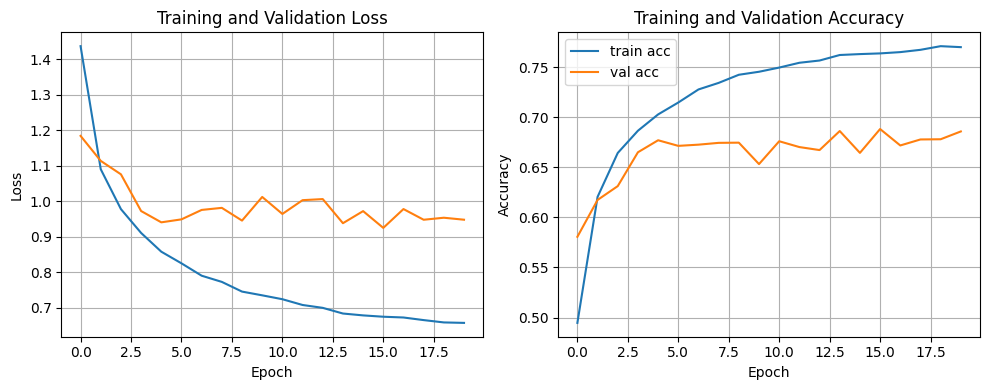

In [ ]:
plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

Acá podemos ver un resumen de los parámetros del modelo base:

In [ ]:
params = model.state_dict()

# Dimensiones de las capas
print('Dimensiones de las capas:')
for name, param in model.named_parameters():
    print(f'\t{name}: {param.shape}')

# Cantidad de parámetros
print('Cantidad de parámetros:')
for key, value in params.items():
    print(f'\t{key}: {torch.numel(value)}')

print(f'Modelo: {model}')

Dimensiones de las capas:
	conv1.weight: torch.Size([16, 3, 3, 3])
	conv1.bias: torch.Size([16])
	conv2.weight: torch.Size([32, 16, 3, 3])
	conv2.bias: torch.Size([32])
	fc.weight: torch.Size([10, 2048])
	fc.bias: torch.Size([10])
Cantidad de parámetros:
	conv1.weight: 432
	conv1.bias: 16
	conv2.weight: 4608
	conv2.bias: 32
	fc.weight: 20480
	fc.bias: 10
Modelo: BaselineModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)


Veamos la matriz de confusión:

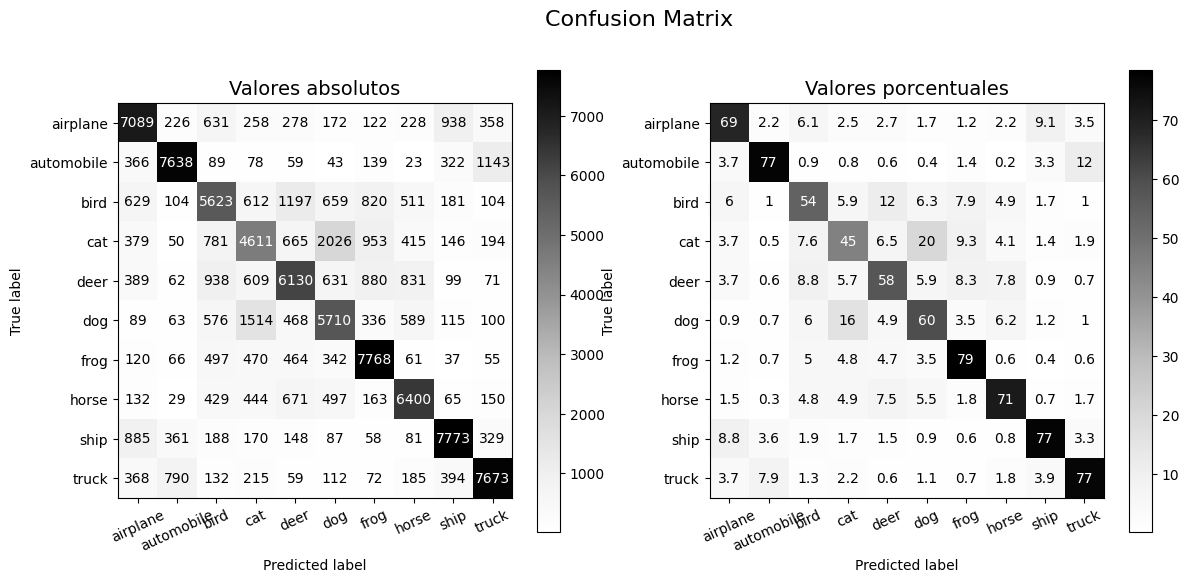

In [ ]:
plotting_confusion_matrix(all_labels, all_preds, title_name='')

Podemos ver que las imágenes que producen mayores errores, mayor al 10%, son entre: perro/gato, camion/automovil, caballo/ciervo.

### Entrenamos el  IntermediateModel

In [ ]:
num_epochs = 20
# Instantiate the network
model = IntermediateModel()
# Instantiate the cross-entropy loss
criterion = nn.CrossEntropyLoss()
# Instantiate the SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)
train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/20, train loss: 1.4743, train acc: 0.5459, val loss: 1.0479, val acc: 0.6352
Epoch 2/20, train loss: 0.9415, train acc: 0.6727, val loss: 0.9708, val acc: 0.6606
Epoch 3/20, train loss: 0.8404, train acc: 0.7084, val loss: 0.8866, val acc: 0.6902
Epoch 4/20, train loss: 0.7698, train acc: 0.7342, val loss: 0.9138, val acc: 0.6862
Epoch 5/20, train loss: 0.7155, train acc: 0.7539, val loss: 0.8750, val acc: 0.6960
Epoch 6/20, train loss: 0.6709, train acc: 0.7684, val loss: 0.8658, val acc: 0.7056
Epoch 7/20, train loss: 0.6377, train acc: 0.7786, val loss: 0.9035, val acc: 0.6994
Epoch 8/20, train loss: 0.6028, train acc: 0.7920, val loss: 0.8636, val acc: 0.7114
Epoch 9/20, train loss: 0.5779, train acc: 0.7990, val loss: 0.9087, val acc: 0.7040
Epoch 10/20, train loss: 0.5542, train acc: 0.8056, val loss: 0.9182, val acc: 0.6976
Epoch 11/20, train loss: 0.5344, train acc: 0.8125, val loss: 0.9325, val acc: 0.7002
Epoch 12/20, train loss: 0.5160, train acc: 0.8164, val loss: 0

Veamos la funciñon de loss y de accuracy tanto para train como para val para el modelo intermedio:

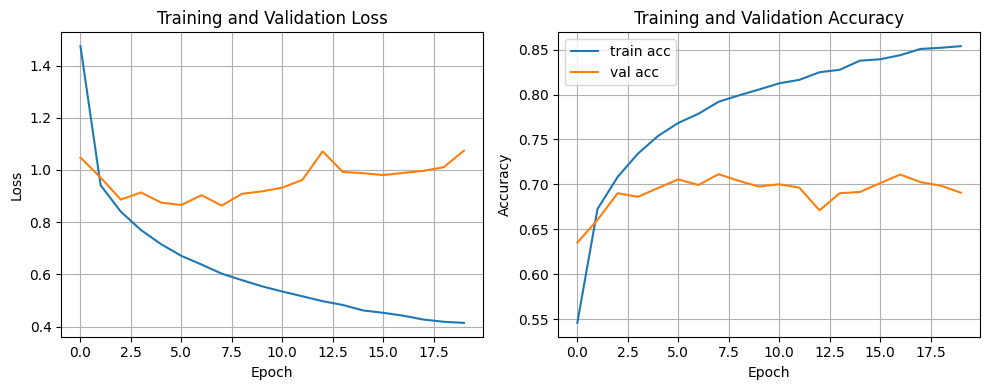

In [ ]:
plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

Acá podemos ver un resumen de los parámetros del modelo intermedio:

In [ ]:
params = model.state_dict()

# Dimensiones de las capas
print('Dimensiones de las capas:')
for name, param in model.named_parameters():
    print(f'\t{name}: {param.shape}')

# Cantidad de parámetros
print('Cantidad de parámetros:')
for key, value in params.items():
    print(f'\t{key}: {torch.numel(value)}')

print(f'Modelo: {model}')

Dimensiones de las capas:
	conv1.weight: torch.Size([32, 3, 3, 3])
	conv1.bias: torch.Size([32])
	batch_norm1.weight: torch.Size([32])
	batch_norm1.bias: torch.Size([32])
	conv2.weight: torch.Size([64, 32, 3, 3])
	conv2.bias: torch.Size([64])
	batch_norm2.weight: torch.Size([64])
	batch_norm2.bias: torch.Size([64])
	fc.weight: torch.Size([10, 4096])
	fc.bias: torch.Size([10])
Cantidad de parámetros:
	conv1.weight: 864
	conv1.bias: 32
	batch_norm1.weight: 32
	batch_norm1.bias: 32
	batch_norm1.running_mean: 32
	batch_norm1.running_var: 32
	batch_norm1.num_batches_tracked: 1
	conv2.weight: 18432
	conv2.bias: 64
	batch_norm2.weight: 64
	batch_norm2.bias: 64
	batch_norm2.running_mean: 64
	batch_norm2.running_var: 64
	batch_norm2.num_batches_tracked: 1
	fc.weight: 40960
	fc.bias: 10
Modelo: IntermediateModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): R

Veamos la matriz de confusión con los resultados en este nuevo modelo:

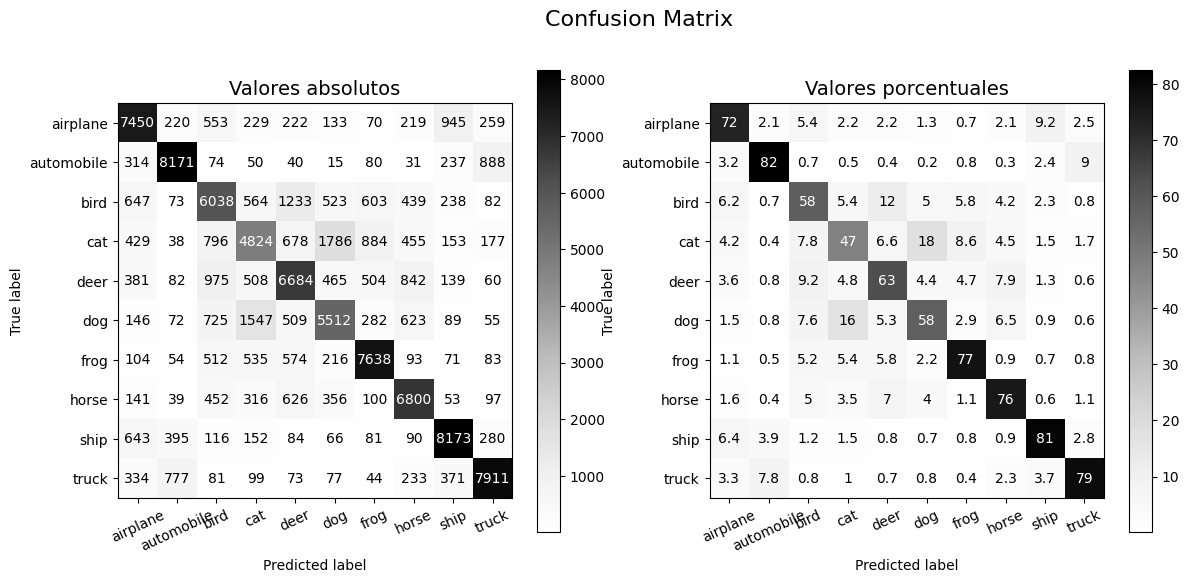

In [ ]:
plotting_confusion_matrix(all_labels, all_preds, title_name='')

Podemos notar que los errores de clasificación han disminido para todos los grupos que mencionamos en el modelo anterior (caballo/ciervo, automovil/camion), que han bajado todos a menos del 10%, salvo para perro/gato.


### Entrenamos el ImprovedAdvancedModel

In [ ]:
num_epochs = 20
# Instantiate the network
model = ImprovedAdvancedModel()
# Instantiate the cross-entropy loss
criterion = nn.CrossEntropyLoss()
# Instantiate the SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)
train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/20, train loss: 1.3545, train acc: 0.5255, val loss: 1.0835, val acc: 0.6256
Epoch 2/20, train loss: 0.9659, train acc: 0.6695, val loss: 0.8717, val acc: 0.6990
Epoch 3/20, train loss: 0.7645, train acc: 0.7369, val loss: 0.7747, val acc: 0.7404
Epoch 4/20, train loss: 0.6097, train acc: 0.7885, val loss: 0.6511, val acc: 0.7748
Epoch 5/20, train loss: 0.4795, train acc: 0.8345, val loss: 0.6221, val acc: 0.7886
Epoch 6/20, train loss: 0.3752, train acc: 0.8680, val loss: 0.6094, val acc: 0.7910
Epoch 7/20, train loss: 0.2946, train acc: 0.8978, val loss: 0.6335, val acc: 0.7988
Epoch 8/20, train loss: 0.2356, train acc: 0.9191, val loss: 0.6299, val acc: 0.7974
Epoch 9/20, train loss: 0.1858, train acc: 0.9345, val loss: 0.6641, val acc: 0.7980
Epoch 10/20, train loss: 0.1609, train acc: 0.9458, val loss: 0.6529, val acc: 0.8056
Epoch 11/20, train loss: 0.1473, train acc: 0.9504, val loss: 0.6386, val acc: 0.8126
Epoch 12/20, train loss: 0.1148, train acc: 0.9623, val loss: 0

Veamso las curvas de loss y accuracy:

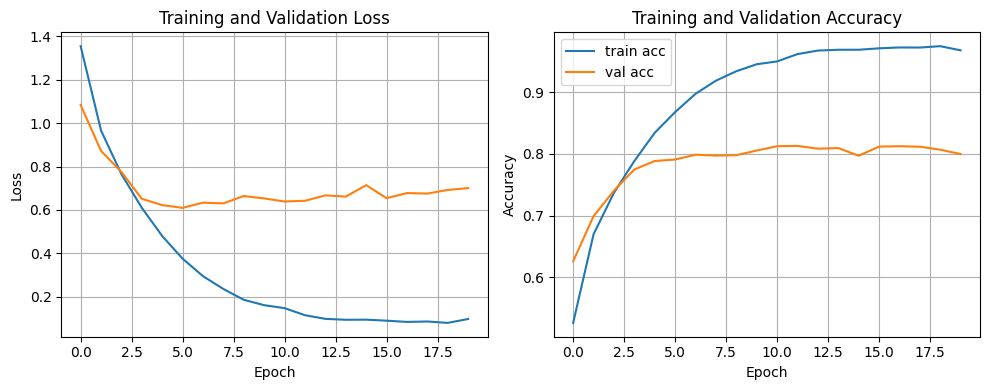

In [ ]:
plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

Podemos ver que la funciñon de loss disminuye rápidamente a medida que pasan las épocas para el grupo de training. En cambio para el caso de validacion se estabiliza bastante, en un valor de 0.7, mejorando respecto al modelo anterior.

El accuracy aumenta rápidamente en el grupo de training, y para el grupo de validación se estabiliza en un valor alrededor de 0.8, mejorando levemente respecto al modelo anterior.

In [ ]:
params = model.state_dict()

# Dimensiones de las capas
print('Dimensiones de las capas:')
for name, param in model.named_parameters():
    print(f'\t{name}: {param.shape}')

# Cantidad de parámetros
print('Cantidad de parámetros:')
for key, value in params.items():
    print(f'\t{key}: {torch.numel(value)}')

print(f'Modelo: {model}')

Dimensiones de las capas:
	conv1.weight: torch.Size([64, 3, 3, 3])
	conv1.bias: torch.Size([64])
	batch_norm1.weight: torch.Size([64])
	batch_norm1.bias: torch.Size([64])
	conv2.weight: torch.Size([128, 64, 3, 3])
	conv2.bias: torch.Size([128])
	batch_norm2.weight: torch.Size([128])
	batch_norm2.bias: torch.Size([128])
	conv3.weight: torch.Size([256, 128, 3, 3])
	conv3.bias: torch.Size([256])
	batch_norm3.weight: torch.Size([256])
	batch_norm3.bias: torch.Size([256])
	fc1.weight: torch.Size([1024, 4096])
	fc1.bias: torch.Size([1024])
	fc2.weight: torch.Size([10, 1024])
	fc2.bias: torch.Size([10])
Cantidad de parámetros:
	conv1.weight: 1728
	conv1.bias: 64
	batch_norm1.weight: 64
	batch_norm1.bias: 64
	batch_norm1.running_mean: 64
	batch_norm1.running_var: 64
	batch_norm1.num_batches_tracked: 1
	conv2.weight: 73728
	conv2.bias: 128
	batch_norm2.weight: 128
	batch_norm2.bias: 128
	batch_norm2.running_mean: 128
	batch_norm2.running_var: 128
	batch_norm2.num_batches_tracked: 1
	conv3.weigh

Veamso la matriz de confusión para este modelo:

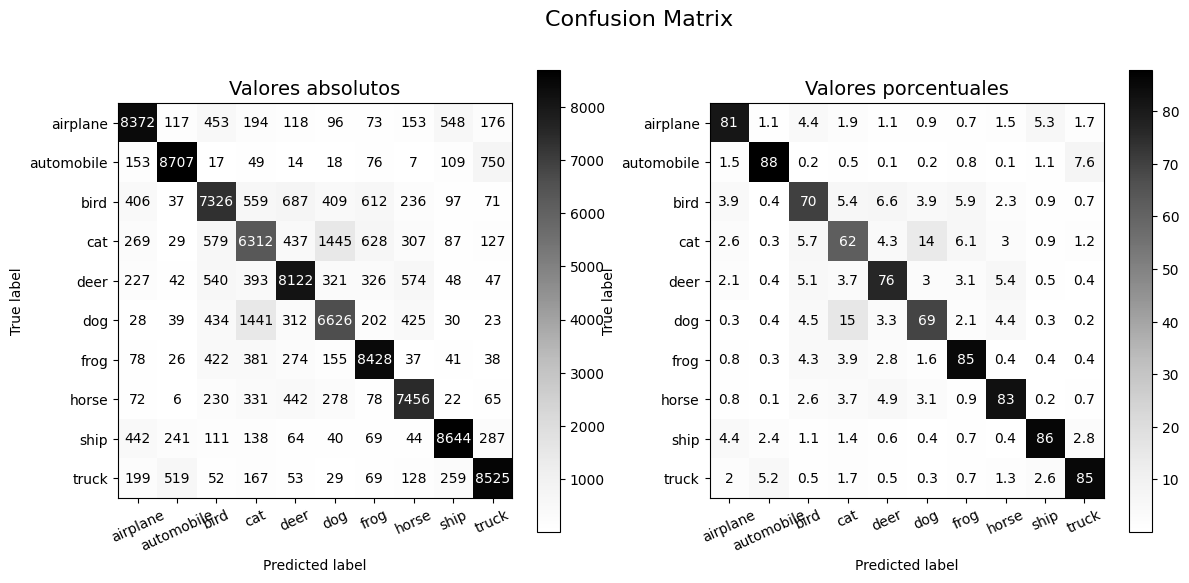

In [ ]:
plotting_confusion_matrix(all_labels, all_preds, title_name='')

La matriz de confusion muestra que han disminuido lso errores para cada par de grupos mencionados previamnete, salvo  perro/gato que ha disminuido levemente y tiene valores de alrededor del 15 %.

## Conclusión de cada modelo

**El modelo BaselineModel**

* Función de Pérdida (Loss):

Train Loss : Inicialmente, la pérdida de entrenamiento es alta y disminuye gradualmente a medida que el modelo aprende. Esto indica que el modelo está mejorando su capacidad para predecir las etiquetas correctas en el conjunto de entrenamiento.
Validation Loss : La pérdida de validación también disminuye al principio, pero parece estabilizarse o incluso aumentar ligeramente hacia el final del entrenamiento.

* Precisión (Accuracy):

Train Accuracy: Aumenta con el tiempo, lo cual es positivo.
Validation Accuracy : Al principio, la precisión de validación mejora, pero parece estabilizarse o disminuir hacia el final.
* Observación Final:

Es posible que se requieran modelos más complejos o técnicas de ajuste fino para mejorar aún más la capacidad de generalización del modelo a nuevos datos.


**El modelo IntermediateModel**

* Función de Pérdida (Loss):

Train Loss: La pérdida de entrenamiento disminuye de manera constante a lo largo de las épocas, lo que indica que el modelo está aprendiendo bien de los datos de entrenamiento.
Validation Loss: La pérdida de validación también disminuye en las primeras épocas, pero parece estabilizarse o aumentar ligeramente hacia el final. Esto podría indicar sobreajuste.
* Precisión (Accuracy):

Train Accuracy: La precisión de entrenamiento aumenta de manera constante, lo cual es positivo.
Validation Accuracy: La precisión de validación alcanza un valor máximo alrededor de la época 7 aproximadamente y luego se mantiene relativamente estable o dentro de un rango, sin crecimientos.
* Observación Final:

El modelo IntermediateModel muestra un buen rendimiento general en términos de pérdida y precisión. Sin embargo, al igual que con el modelo anterior, se observa una estabilización o ligero aumento en la pérdida de validación hacia el final, y la gran diferencia entre las curvas de train y validación estarían indicando que hay sobreajuste.

**El modelo ImprovedAdvancedModel**

* Función de Pérdida (Loss):

Train Loss: disminuye de manera constante a lo largo de las épocas, indicando que el modelo está aprendiendo.
Validation Loss: la pérdida de validación baja hasta 0.7.

* Precisión (Accuracy):

Train Accuracy: aumenta progresivamente, alcanzando un nivel alto cercano a 1.
Validation Accuracy: Laumenta y se estabiliza en valores cercanos a 0.8.
* Observación Final:

El modelo ImprovedAdvancedModel muestra un rendimiento más sólido que los otros modelos, con una pérdida y precisión tanto en entrenamiento como en validación que indican una buena capacidad de aprendizaje. Sin embargo pareciera que el modelo presenta sobreajuste ya que tanto la función de pérdida como la precisión se estabilizan a valores un poco diferentes, en los grupos de train y de validación.


## Conclusión general

Todos los modelos muestran una mejora progresiva en la precisión y una disminución de la pérdida a lo largo de las épocas, lo que indica aprendizaje. Tambien podemos observar que las curvas tienen a tener un comportamiento estable, independientemente del valor. Sin embargo consideramos que todos los modelos presentan uun poco de sobreajuste, evidenciado en las curvas de train y validación, que se estabilizan a valores bastante diferentes.
A mayor complejidad del modelo, tiende a mejorar el rendimiento lgorado, aunque no logramos eliminar el sobreajuste.
Finalmente, el ImprovedAdvancedModel parece ser el más avanzado en términos de rendimiento.